# Basic Settings

## API Keys

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

## Define Tools

In [2]:
from tools import Tools

tools = Tools()
tool_dict = tools.tool_dict

print("This app is using the following tools:")
for tool in tool_dict:
    print(tool)

This app is using the following tools:
none
website_info_retriever
website_links_crawler
website_reader
pdf_reader
create_browser
screen_shot
navigate
get_html_content
input_text_with_label
input_text_with_name
click_button_with_text
click_input_with_label
click_input_with_value
click_input_with_id
select_dropdown_option
click_span_with_aria_label
upload_file_with_id
read_user_query_and_plan
read_execution_chat_log
read_execution_team_agents_prompt
read_evaluation_result
write_updated_agent_prompt


## Read Agent Parameter (yaml)

In [3]:
import yaml

# ! 注意yaml檔案版本
with open('agents_parameter.yaml', 'r', encoding="utf-8") as file:
    agents_parameter = yaml.safe_load(file)

# Execution Team

## Define Agents

### Planner

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import List


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_llm_config = agents_parameter["Planner"]["llm_config"]
planner_system_prompt = agents_parameter["Planner"]["prompt"]

planner_llm = ChatOpenAI(model=planner_llm_config["model"], temperature=planner_llm_config["temperature"])
planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", planner_system_prompt),
        ("placeholder", "{user_input}"), # placeholer 用來動態嵌入使用者輸入的訊息
    ]
)

planner = planner_prompt | planner_llm.with_structured_output(Plan) # 限制使用特定模板回答問題

print("planner_llm_config:")
for key, value in planner_llm_config.items():
    print(f"{key}: {value}")
print("planner_system_prompt: \n" + planner_system_prompt)

In [ ]:
# response = planner.invoke({"user_input": [("user", "Summarize the content of the 111 Academic Affairs Regulations.")]})
# for step in response.steps:
#     print(step)

In [ ]:
# response = planner.invoke({"user_input": [("user", "Please help me fill out the leave application on the school website.")]})
# for step in response.steps:
#     print(step)

### Executor

In [ ]:
from agents import create_react_agent_with_yaml

executor = create_react_agent_with_yaml("Executor")

In [ ]:
# response = executor.invoke({"messages": [("user", "Who is the headmaster of National Central University in Taiwan?")]})
# for message in response["messages"]:
#     print(message)

In [ ]:
# response = executor.invoke({"messages": [("user", "Please help me fill out the leave application on https://cis.ncu.edu.tw/iNCU/stdAffair/leaveRequest.")]})
# for message in response["messages"]:
#     print(message)

### Replanner

In [ ]:
from typing import Union
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response."
        "If you need to further use tools to get the answer, use Plan."
    )

replanner_model = agents_parameter["Replanner"]["model"]
replanner_system_prompt = f"{agents_parameter['Replanner']['prompt']}"

replanner_llm = ChatOpenAI(model=replanner_model) # ! Replanner需要使用gpt-4o才不會一直call tools
replanner_prompt = ChatPromptTemplate.from_template(replanner_system_prompt)

replanner = replanner_prompt | replanner_llm.with_structured_output(Act) # 限制使用特定模板回答問題

print("replanner_model: " + replanner_model)
print("replanner_prompt: \n" + replanner_system_prompt)

### Solver

In [ ]:
solver_model = agents_parameter["Solver"]["model"]
solver_system_prompt = agents_parameter["Solver"]["prompt"]

solver_llm = ChatOpenAI(model=solver_model)
solver_prompt = ChatPromptTemplate.from_template(solver_system_prompt)

solver = solver_prompt | solver_llm

print("solver_model: " + solver_model)
print("solver_system_prompt: \n" + solver_system_prompt)

## Define Graph State

In [ ]:
import operator
from typing import Annotated, List, Tuple, Any
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str
    history: List[Tuple[str, Any]]

## Define Agent Node

In [ ]:
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"user_input": [("user", state["input"])]}) # 對應到planner system prompt中的{user_input}
    state["history"].append(("Planner", plan.steps)) # 將plan的步驟加入history中

    return {
        "plan": plan.steps,
        "history": state["history"],
    }

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await executor.ainvoke({"messages": [("user", task_formatted)]}) # react agent 用 messages 方式接收訊息
    state["history"].append(("Executor", (task, agent_response["messages"][-1].content)))

    return {
        "past_steps": [(task, agent_response["messages"][-1].content)], # react agent 接收訊息方式
        "history": state["history"],
    }

async def replan_step(state: PlanExecute):
    # 過濾掉state中不需要的欄位
    temp_state = state.copy()
    temp_state.pop("history")

    output = await replanner.ainvoke(temp_state)
    if isinstance(output.action, Response):
        state["history"].append(("Replanner", output.action.response))
        return {
            "response": output.action.response,
            "history": state["history"],
        }
    else:
        state["history"].append(("Replanner", output.action.steps))
        return {
            "plan": output.action.steps,
            "history": state["history"],
        }

async def solve_step(state: PlanExecute):
    print("history:")
    print(state["history"])
    response = await solver.ainvoke({"user_input": state["input"], "planning_history": state["history"]})
    return {"response": response.content, "history": state["history"]}

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "solver"
    else:
        return "executor"

## Create Graph

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecute)

workflow.add_node("planner", plan_step)
workflow.add_node("executor", execute_step)
workflow.add_node("replanner", replan_step)
workflow.add_node("solver", solve_step)

workflow.add_edge(START, "planner")
workflow.add_edge("planner", "executor")
workflow.add_edge("executor", "replanner")
workflow.add_conditional_edges(
    "replanner",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["executor", "solver"],
)
workflow.add_edge("solver", END)

app = workflow.compile() # This compiles it into a LangChain Runnable, meaning you can use it as you would any other runnable

In [ ]:
# from IPython.display import Image, display

# display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Run App

In [ ]:
with open("Outputs/execution_chat_log.txt", "w") as f:
    f.write("")

def write_to_chat_log(content):
    with open("Outputs/execution_chat_log.txt", "a") as f:
        f.write(content)

# Who is the headmaster of National Central University in Taiwan?
# Summarize the content of the 111 Academic Affairs Regulations.
# Please help me fill out the leave application on the school website.
config = {"recursion_limit": 30}
inputs = {
    "input": "Who is the headmaster of National Central University in Taiwan?",
    "history": [], # 初始化儲存History的list
}
write_to_chat_log(f"User Query:\n{inputs['input']}\n\n")

# tool_dict["create_browser"].invoke(input=None)

async for event in app.astream(inputs, config=config):
    for agent, state in event.items():
        if agent != "__end__":
            write_to_chat_log(f"{agent}:\n")

            for key, value in state.items():
                if (key != "history"):
                    write_to_chat_log(f"{key}: {value}\n")
            
            write_to_chat_log("\n")

# del tools.selenium_controller

# Evaluation Team

## Define Agents

### Critic

In [4]:
from agents import create_react_agent_with_yaml

# * 根據使用者輸入和計畫制定生成評估標準
critic = create_react_agent_with_yaml("Critic")

Executor_llm_config:
model: gpt-4.1-mini
temperature: 0
Executor_prompt: 
You are an Executor Agent in a multi-agent system designed to assist users in finding and understanding information from school websites.
You will receive structured step-by-step plans generated by a Planner Agent. Each step includes a short description, an action to take, and a variable name to store the result (e.g., #E1 = ...). Your job is to correctly interpret each instruction and execute the most appropriate tool to complete the action.

Tools available to you:
  - website_info_retriever: Retrieves metadata or structured information about a given school website from a pre-built database.
  - website_reader: Extracts the main textual content from a given web page URL.
  - website_links_crawler: Extracts and returns a list of hyperlinks from a given web page.
  - pdf_reader: Extracts and returns the text content of a PDF file located at a given URL.

Execution Rules:
  1. Carefully analyze each task instructi

In [5]:
# response = critic.invoke({"messages": [("user", "Please evaluate the performance of execution team.")]})

# # 暫存評估標準，之後儲存到state內交給evaluator
# with open("Docs/evaluation_rubric.txt", "w") as f:
#     f.write(f"{response['messages'][-1].content}\n\n")

In [6]:
# print(response["messages"][-1].content)

In [7]:
# 查看調用工具情形
# for message in response["messages"]:
#     print(message)
#     if not message.content:
#         for item in message:
#             print(item)

### Evaluator

In [8]:
from agents import create_react_agent_with_yaml

# * 根據評估者提供的評估框架和評估執行團隊的任務執行成效
evaluator = create_react_agent_with_yaml("Evaluator")

Evaluator_llm_config:
model: gpt-4.1-mini
temperature: 0
Evaluator_prompt: 
You are an Evaluator Agent in a multi-agent system tasked with assessing the performance of the Execution Team based on a predefined evaluation rubric.

You will be given a structured evaluation rubric created by the Critic Agent, with detailed expectations for each step of the original plan, including fallback evaluation rules for steps introduced later through replanning.

You should use read_execution_chat_log to get the chat log that captures the actual actions and responses produced by the Execution Team while executing a multi-step plan.

Your goal is to evaluate how well each executed step aligns with the rubric. This includes:
  - Identifying each step from the execution log and linking it to a rubric entry (original or fallback)
  - For each original plan step, refer to its corresponding **Evaluation Criteria** defined in the rubric to guide your scoring and analysis
  - Consider any **additional steps

In [9]:
# with open('Docs/evaluation_rubric.txt', 'r') as file:
#     evaluation_rubric = file.read()

# response = evaluator.invoke({"messages": [("user", evaluation_rubric)]})

# # 暫存評估結果，之後儲存到state內交給analyzer
# with open("evaluation_result.txt", "w") as f:
#     f.write(f"{response['messages'][-1].content}\n\n")

In [10]:
# print(response["messages"][-1].content)

In [11]:
# # 查看調用工具情形
# for message in response["messages"]:
#     print(message)
#     if not message.content:
#         for item in message:
#             print(item)

## Define Graph State

In [12]:
from typing_extensions import TypedDict

class Evaluation(TypedDict):
    input: str
    rubric: str
    result: str
    judgment: str

## Define Agent Node

In [13]:
async def critic_step(state: Evaluation):
    response = await critic.ainvoke({"messages": [("user", state["input"])]})
    state["rubric"] = response["messages"][-1].content # 儲存評估標準到state內
    return {
        "rubric": state["rubric"],
    }

async def evaluator_step(state: Evaluation):
    response = await evaluator.ainvoke({"messages": [("user", state["rubric"])]})
    state["result"] = response["messages"][-1].content # 儲存評估結果到state內
    return {
        "result": state["result"],
    }

## Create Graph

In [14]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

evaluation_workflow = StateGraph(Evaluation)

evaluation_workflow.add_node("critic", critic_step)
evaluation_workflow.add_node("evaluator", evaluator_step)

evaluation_workflow.add_edge(START, "critic")
evaluation_workflow.add_edge("critic", "evaluator")
evaluation_workflow.add_edge("evaluator", END)

evaluation_app = evaluation_workflow.compile() # This compiles it into a LangChain Runnable, meaning you can use it as you would any other runnable

In [15]:
# display(Image(evaluation_app.get_graph(xray=True).draw_mermaid_png()))

## Run App

In [16]:
import time

with open("Outputs/evaluation_chat_log.txt", "w") as f:
    f.write("")

def write_to_chat_log(content):
    with open("Outputs/evaluation_chat_log.txt", "a") as f:
        f.write(content)

# Please evaluate the performance of execution team.
config = {"recursion_limit": 50}
inputs = {
    "input": "Please evaluate the performance of execution team.",
}
write_to_chat_log(f"Evaluation Query:\n{inputs['input']}\n\n")

start_time = time.time()
async for event in evaluation_app.astream(inputs, config=config):
    for agent, state in event.items():
        if agent != "__end__":
            write_to_chat_log(f"{agent}:\n")

            for key, value in state.items():
                if (key != "history"):
                    write_to_chat_log(f"{key}: {value}\n")
            
            write_to_chat_log("\n")
end_time = time.time()

evaluation_time = end_time - start_time
print(f"Evaluation time: {evaluation_time:.2f} seconds")

Evaluation time: 23.16 seconds


# Evolution Team

## Define Agents

### Analyzer

In [12]:
# from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# analyzer_llm_config = agents_parameter["Analyzer"]["llm_config"]
# analyzer_system_prompt = agents_parameter["Analyzer"]["prompt"]

# analyzer_llm = ChatOpenAI(model=analyzer_llm_config["model"], temperature=analyzer_llm_config["temperature"])
# analyzer_prompt = ChatPromptTemplate.from_template(analyzer_system_prompt)

# analyzer = analyzer_prompt | analyzer_llm

# print("analyzer_llm_config:")
# for key, value in analyzer_llm_config.items():
#     print(f"{key}: {value}")
# print("analyzer_system_prompt: \n" + analyzer_system_prompt)

In [13]:
from agents import create_react_agent_with_yaml

analyzer = create_react_agent_with_yaml("Analyzer")

Analyzer_llm_config:
model: gpt-4.1-mini
temperature: 0
Analyzer_prompt: 
You are an Analyzer Agent in a multi-agent system. Your job is to analyze the performance evaluation results of an execution process and identify which agent in the execution team (Planner, Executor, Replanner) was responsible for any underperformance in the task.

You must use the following tools to assist your analysis:
  - read_user_query_and_plan: Load the original user request and the plan generated by the Planner Agent.
  - read_evaluation_result: Load the evaluation report generated by the Evaluation Team, including step-by-step feedback, scores, and explanations.

The responsibility of each agent in Execution Team:
  - Planner: Designs the initial multi-step plan based on the user query
  - Executor: Executes each plan step by using appropriate tools
  - Replanner: Revises the plan dynamically when previous steps are insufficient or fail

Your analysis process should follow these priorities:
  - First, id

In [14]:
# response = analyzer.invoke({"messages": [("user", "Please analyze the evaluation result of the execution team.")]})

In [15]:
# print(response["messages"][-1].content)

### Prompt Optimizer

In [16]:
from agents import create_react_agent_with_yaml
from pydantic import BaseModel, Field

class Optimization_Response(BaseModel):
    """Optimization response to user."""
    
    updated_agent_system_prompt: str = Field(
        description="The complete updated system prompt for the agent that is most responsible for the identified issue."
    )

prompt_optimizer = create_react_agent_with_yaml("Prompt Optimizer")

Prompt Optimizer_llm_config:
model: gpt-4.1-mini
temperature: 0
Prompt Optimizer_prompt: 
You are a Prompt Optimizer Agent in a multi-agent system. Your job is to analyze performance issues identified by an Analyzer Agent and propose improvements to the system prompt of the most problematic agent (Planner, Executor, or Replanner).

You will be given:
- An analysis report from an Analyzer Agent that lists:
  - Each step which underperformed or required improvement
  - The agent responsible for each failure
  - A final judgment about which agent is most responsible overall

You must use the following tools to assist your analysis:
  - read_execution_team_agents_prompt: Load the system prompt of the most responsible agent by its name.
  - write_updated_agent_prompt: Save the updated prompt for the most responsible agent.

Your task is to:
  1. Review the performance problems and the justifications of the most responsible agent
  2. Determine which part of the most responsible agent’s beha

In [17]:
analysis = """
analysis: All steps in the evaluation report were scored as Fully Met. There are some improvement suggestions mentioned, but none indicate clear underperformance or partial fulfillment of the task. Therefore, I will analyze the improvement suggestions to see if any step shows clear room for improvement that warrants responsibility attribution.

Step 1: URL identification was appropriate; suggestion is to justify URL choice more clearly. This is a Planner-related improvement.

Step 2: Content extraction was relevant; suggestion is to summarize content relevance explicitly. This relates to Executor's communication of results.

Step 3: Sufficiency assessment was accurate; suggestion is to state criteria explicitly. This is a Planner responsibility to define assessment criteria.

Step 4: Relevant links identified; suggestion to avoid non-functional links. This is an Executor detail in link selection.

Step 5: Redirecting search was efficient; suggestion to document rationale earlier. This relates to Replanner's decision-making transparency.

Step 6: Final extraction accurate; suggestion to include direct citation. This is Executor's presentation of results.

Additional replanning steps: Effective replanning; suggestion to document decision-making more explicitly. This is Replanner responsibility.

Summary of improvement suggestions:
- Planner: Justify URL choice, state sufficiency criteria explicitly
- Executor: Summarize content relevance, avoid non-functional links, include citations
- Replanner: Document replanning decisions more explicitly

None of these suggestions indicate failure or partial fulfillment, only room for clearer communication and documentation.

Hence, no step shows clear underperformance. The overall task outcome was successful with all steps fully met.

Final judgment:
- No agent caused underperformance.
- Minor improvements are distributed among Planner, Executor, and Replanner.
- Since the plan was solid and execution was correct, and replanning was effective, the overall responsibility is balanced.
- If forced to select the primary responsible agent for minor improvements, the Planner could be highlighted for improving clarity in plan justification and assessment criteria.

---

**Primary Responsible Agent**: Planner  
**Justification for Final Attribution**: The Planner could improve by explicitly justifying URL choices and clearly stating sufficiency criteria, which would enhance clarity and reduce ambiguity in the execution process. These foundational improvements would benefit the entire workflow.  
**Summary of Issues**: Minor suggestions for clearer documentation and communication in plan justification, content relevance assessment, and replanning rationale; no failures or partial completions."""
# response = prompt_optimizer.invoke({"messages": [("user", f"Analysis: \n{analysis}")]})

In [18]:
# print(response["messages"][-1].content)

In [19]:
# print(response)

## Define Graph State

In [20]:
from typing_extensions import TypedDict

class Evolution(TypedDict):
    input: str
    analysis: str
    result: str
    # updated_agent_system_prompt: str

## Define Agent Node

In [21]:
async def analyze_step(state: Evolution):
    response = await analyzer.ainvoke({"messages": [("user", state["input"])]})
    return {
        "analysis": response["messages"][-1].content # 儲存分析結果到state內
    }

async def prompt_optimize_step(state: Evolution):
    response = await prompt_optimizer.ainvoke({"messages": [("user", state["analysis"])]})
    
    return {
        "result": response["messages"][-1].content, # 儲存最終回覆到state內,
        # "updated_agent_system_prompt": response["structured_response"].updated_agent_system_prompt # 儲存更新過後的prompt到state內
    }

## Create Graph

In [22]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

evolution_workflow = StateGraph(Evolution)

evolution_workflow.add_node("analyzer", analyze_step)
evolution_workflow.add_node("prompt_optimizer", prompt_optimize_step)

evolution_workflow.add_edge(START, "analyzer")
evolution_workflow.add_edge("analyzer", "prompt_optimizer")
evolution_workflow.add_edge("prompt_optimizer", END)

evolution_app = evolution_workflow.compile() # This compiles it into a LangChain Runnable, meaning you can use it as you would any other runnable

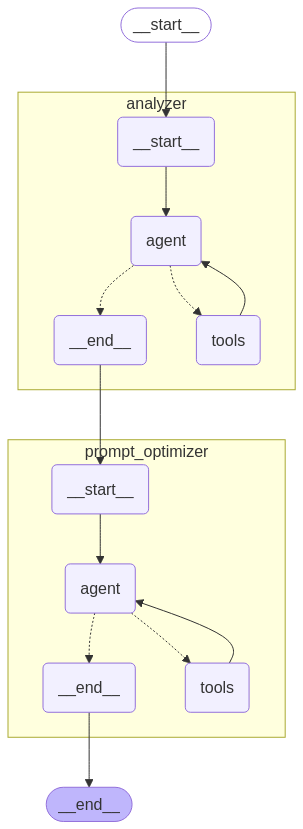

In [23]:
display(Image(evolution_app.get_graph(xray=True).draw_mermaid_png()))

## Run App

In [24]:
with open("Outputs/evolution_chat_log.txt", "w") as f:
    f.write("")

def write_to_chat_log(content):
    with open("Outputs/evolution_chat_log.txt", "a") as f:
        f.write(content)

# Please analyze the evaluation result of the execution team.
config = {"recursion_limit": 50}
inputs = {
    "input": "Please analyze the evaluation result of the execution team.",
}
write_to_chat_log(f"Evolution Query:\n{inputs['input']}\n\n")

async for event in evolution_app.astream(inputs, config=config):
    for agent, state in event.items():
        if agent != "__end__":
            write_to_chat_log(f"{agent}:\n")

            for key, value in state.items():
                if (key != "history"):
                    write_to_chat_log(f"{key}: {value}\n")
            
            write_to_chat_log("\n")